# Detecting meiotic drive using RADseq of pooled embryos

*Sarah E. Lower*
*3.3.2017*

**Goal: to figure out how many loci, what depth,and how many pooled offspring I need to sample to detect drive**

**General plan**
1. Simulate chromosomes in F1 hybrids (P1, P2)
2. Generate offspring
    * simulate recombination based on Dmel recombination map
    * simulate drive (parameter), by sampling recombinant offspring according to genotype at drive locus
    * after sampling given number of offspring (parameter), dilute with P1 genotype
3. Generate reads
    * sample chromosomes (with replacement) according to some read depth
4. Estimate drive (location, magnitude, statistical significance)
5. Repeat for all sorts of different parameter sets



**Parameters:**

hardcoded: recombination maps for Drosophila melanogaster v5.36 2L, 2R, 3L, 3R, X

inputs: which chromosome, location on chromosome, strength of drive, how many loci (evenly spaced- can change to random?), how many individuals

assumptions: loci equally distributed among and within chromosomes, all are informative

v.1: with idealized assumptions
2: with enzymes I have selected (TaqalphaI and EcoRI)


In [2]:
import numpy as np #for generating random boolean
import scipy as sp
from scipy import stats
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import time #to get an idea how long things take
from sympy import * #symbolic
import sympy as sm
import scipy.integrate as integrate
import scipy.optimize as optimize

### Function: build_recombination_guide(recombination_frequency)
This function will take as input a list of recombination frequencies between loci (in order 5' to 3') for a chromosome and a number of individuals. It makes an numpy array of the recombination breaks, where each row represents a haploid individual and each column is whether there is (1) or is not (0) recombination between the adjacent loci. 

In [50]:
def build_recombination_guide(recombination_frequency, n_individuals):
    print(np.sum(recombination_frequency))
    n_intervals=len(recombination_frequency) #to get the width of the desired array
    chromosome_recombination_guides=sp.stats.bernoulli.rvs(recombination_frequency, size=(n_individuals, n_intervals))
    return chromosome_recombination_guides;

### Function: get_recombined_chromosomes(recomb_guide)
This function will take as input a table of recombination guides (1/0) between loci for a set of chromosomes from N individuals. It produces a synthetic chromosome for each individual and returns a data frame where each individual is a column and each locus a row. *0* = P1 allele. *1* = P2 allele.

In [4]:
def get_recombined_chromosomes(recomb_guide):
    
    n_ind,n_intervals=recomb_guide.shape
    haploid_chromosomes = np.ndarray((n_ind, n_intervals+1)) #Make an ndarray of n_ind rows by n_intervals+1 columns (loci)

    haploid_chromosomes.fill(0) #Fill the array with zeros... otherwise numpy fills it with weird numbers.

    for i in range(n_ind): #for each row (individual chromosome)
        
        #Identify every recombination break point, turn this into a list, and add a final index to the end to complete the pair
        rec_indices=list(np.where(recomb_guide[i,:]==1)[0])+[n_intervals]

        #Iterate over every other recombination breakpoint, starting with the first, and fill the array with ones between it and the next break point.
        for j in range(0, len(rec_indices)-1,2): #go by twos
            haploid_chromosomes[i,1+rec_indices[j]:1+rec_indices[j+1]]=1

    return haploid_chromosomes

### Function invert_chr(chr)

This function will take a chromosome as a list of 0 and 1, invert it (get the other recombinant chromosome), and return the chromosome as a dataframe.

In [5]:
def invert_chr(chr):
    chromosome=[]
        
    for locus in chr:
        locus = 1 - locus
        chromosome.append(locus)
        
    return chromosome

### Function sim_drive(drive_strength, drive_location, drive_genotype, haploid_chromosomes)

This function will generate a set of chromosomes that represent the gametes from the F1 female that get into the egg with frequency governed by the drive locus. 

In [6]:
def sim_drive(drive_strength, drive_location, drive_genotype, haploid_chromosomes):
    
    #get array of genotypes at the drive position
    genotype_at_drive_locus=haploid_chromosomes[:,drive_location-1]

    #calculate probability of drive allele transmission (allele freq)
    prob_drive_transmission=(drive_strength*0.5)+0.5

    #function to convert genotypes at drive locus to probability of transmitting that allele
    def f(x):
        return prob_drive_transmission if x == drive_genotype else 1-prob_drive_transmission;
    f=np.vectorize(f)
    result_array=f(genotype_at_drive_locus)

    #construct chromosome survival array (length=number of individuals) of bernoulli variables 
    #derived from probability distributions in result array to say if should keep current chromosome
    #(more likely with drive) or get the sister; 1 means keep the drive chromosome, 0 is change to non drive
    vector_surv=sp.stats.bernoulli.rvs(result_array)

    #get indices of the survival vector where drive does/does not take place
    survive_indices=list(np.where(vector_surv[:,]==1)[0])
    invert_indices=list(np.where(vector_surv[:,]==0)[0])

    #keep drive chromosomes, invert the chromosomes that aren't driven
    survive_chromosomes=haploid_chromosomes[survive_indices,:]
    invert_chromosomes=np.apply_along_axis(invert_chr, 0, haploid_chromosomes[invert_indices,:])

    #concatenate the sets into an array
    chromosome_set=np.concatenate((survive_chromosomes, invert_chromosomes), axis=0)

    return chromosome_set

### Function add_male_genotypes(backcross_offspring, male_allele)

This function will generate the complete set of chromosomes for the offspring (including the chromosome from the homozygous male parent) for simulated sequencing.

In [7]:
def add_male_genotypes(backcross_offspring, male_allele):

    #define dimensions of array (want to reproduce same as backcross offspring)
    num_rows,num_cols=backcross_offspring.shape

    #make array, fill with male allere, and concatenate
    males=np.ndarray((num_rows, num_cols), dtype=int) #try full_like
    males.fill(male_allele)
    all_chromes=np.concatenate((backcross_offspring, males), axis=0)
    
    #return the ndarray of all_chromes
    return all_chromes

### Functions phys_loc_to_gen_loc...chromosome(x)

This function will return the genetic location (cM) for chromosomes. 

From Anne-Marie: We use recombination rates from Fiston-Lavier et al. 2010, release 5.36. 

In [8]:
def phys_loc_to_gen_loc_2L(x):
    gen_loc=-0.01*x**3+0.20*x**2+2.59*x-1.56
    return gen_loc   

In [9]:
def phys_loc_to_gen_loc_2R(x):
    gen_loc=-0.007*x**3+0.35*x**2-1.43*x+56.91
    return gen_loc   

In [10]:
def phys_loc_to_gen_loc_3L(x):
    gen_loc=-0.006*x**3+0.09*x**2+2.94*x-2.90
    return gen_loc 

In [11]:
def phys_loc_to_gen_loc_3R(x):
    gen_loc=-0.004*x**3+0.24*x**2-1.63*x+50.26
    return gen_loc   

In [12]:
def phys_loc_to_gen_loc_X(x):
    gen_loc=-0.01*x**3+0.30*x**2+1.15*x-1.87
    return gen_loc   

### Function plot_phys_loc_by_gen_loc(chromosome, number_of_loci)

This function, given a chromosome (2L, 2R, 3L, 3R, X) and number of loci, return the plot of phys location Mb (x) vs genetic location cM (y). You can see if the plot matches the ones here:http://petrov.stanford.edu/cgi-bin/recombination-rates_updateR5.pl#Method

In [13]:
def plot_phys_loc_by_gen_loc(chromosome, number_of_loci):
    
    #list of chromosome names
    chromosome_names=["2L", "2R", "3L", "3R", "X"]
    #Define lengths of chromosome - got by grepping chrx names from data/Kevin/reference/ dmel-all-chromosome-r5.46.fasta file
    chromosome_lengths=[23.011544, 21.146708, 24.543557,27.905053,22.422827]
    
    #Choose chromosome
    chrx=chromosome

    #get chrx_idx
    chrx_idx=chromosome_names.index(chrx)

    #Define desired number of loci to sequence in genome
    num_loci=number_of_loci

    #Get length of chosen chromosome
    length=chromosome_lengths[chrx_idx]

    #calculate intervals
    interval=length/num_loci

    #physical location windows
    phys_loc=np.arange(0,length+1, interval)

    #convert physical location (mb) to genetic location
    wording='phys_loc_to_gen_loc_' + chrx

    gen_loc=eval(wording)(phys_loc)

    if np.any(gen_loc<0): #Reassign negative genetic locations to 0 and anything >50cM to 50cM (true for driver at position 0)
        gen_loc=np.clip(gen_loc,0,50)

        if np.amax(gen_loc>=50):
            #Change everything after 50 to 50
            boundary=np.amax(np.where(gen_loc==50))
            end=gen_loc.shape[0]
            gen_loc[boundary:end,]=50
        else:
            #Change everything after max to max
            boundary=np.argmax(gen_loc)
            max_val=np.amax(gen_loc)
            end=gen_loc.shape[0]
            gen_loc[boundary:end,]=max_val

    else:
        gen_loc=np.clip(gen_loc,50,100)

        if np.amin(gen_loc>50):
            #Change everything before min to min
            boundary=np.argmin(gen_loc)
            min_val=np.amin(gen_loc)
            gen_loc[0:boundary,]=np.amin(gen_loc)

    #Plot to make sure looks like Anne-Marie's- yes
    return plt.scatter(phys_loc, gen_loc)

### Testing to make sure equations recapitulate figures from web.

Make plots of physical location vs genetic location across the chromosome. Should look like figs at http://petrov.stanford.edu/cgi-bin/recombination-rates_updateR5.pl#Method

Note: In subsequent analysis, all derivatives need to be constrained to be positive

Text(0, 0.5, 'Genetic location (cM)')

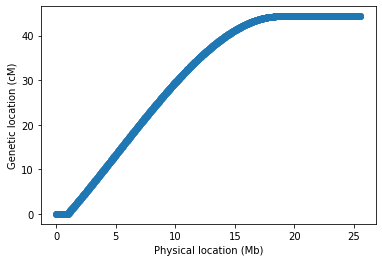

In [14]:
plot_phys_loc_by_gen_loc("3L", 1000)
plt.xlabel("Physical location (Mb)")
plt.ylabel("Genetic location (cM)")

### Function get_recombination_probability(chromosome, number of loci)

This function, for a given chromosome and number of loci, yield the recombination probability vector (recombination frequency corrected for detection of an odd-number of crossovers).

In [32]:
def get_recombination_probability(chromosome, number_of_loci):
    
    #dummy variables for testing
    #chromosome="X"
    #number_of_loci=1000

    #list of chromosome names
    chromosome_names=["2L", "2R", "3L", "3R", "X"]

    #Define lengths of chromosome - got by grepping chrx names from data/Kevin/reference/ dmel-all-chromosome-r5.46.fasta file
    chromosome_lengths=[23.011544, 21.146708, 24.543557,27.905053,22.422827]

    length_dict=dict(zip(chromosome_names, chromosome_lengths))

    #Get length of chosen chromosome
    length=length_dict[chromosome]

    #Define desired number of loci
    num_loci=number_of_loci

    #set bounds of euchromatin
    chromosome_bounds_dict={"2L":(0.54,18.10247786560563), "2R":(2.186247484801114, 20.86), "3L":(0.75, 18.723459233492605), "3R":(3.7467951878201364, 27.44), "X":(1.22,21.21)}
                       
    #physical location windows
    phys_loc=np.linspace(chromosome_bounds_dict[chromosome][0],chromosome_bounds_dict[chromosome][1], num_loci)

    if chromosome=="2L":
        def get_g_pos(x):
            g_pos=-0.01*x**3+0.20*x**2+2.59*x-1.56
            return g_pos
    elif chromosome=="2R":
        def get_g_pos(x):
            g_pos=-0.007*x**3+0.35*x**2-1.43*x+56.91
            return g_pos
    elif chromosome=="3L":
        def get_g_pos(x):
            g_pos=-0.006*x**3+0.09*x**2+2.94*x-2.90
            return g_pos
    elif chromosome=="3R":  
        def get_g_pos(x):
            g_pos=-0.004*x**3+0.24*x**2-1.63*x+50.26
            return g_pos
    elif chromosome=="X":
        def get_g_pos(x):
            g_pos=-0.01*x**3+0.30*x**2+1.15*x-1.87
            return g_pos

    g_pos=get_g_pos(phys_loc)
    #plt.plot(g_pos)
    #plt.show()
    
    diffs_array=np.absolute(np.diff(g_pos))

    def get_corrected_recombination_probability(x):
        return (1-np.exp((-2*x)/100))/2

    corrected_recomb_prob=get_corrected_recombination_probability(diffs_array)
   
    return corrected_recomb_prob,phys_loc,g_pos

In [48]:
p, phys_loc, g_loc = get_recombination_probability(chromosome='2L', number_of_loci=10)


### Function find_expected_allele_freq(genetic_position, hyp_drive_location, drive_strength)
This function will take as input a numpy array of genetic positions along a chromosome, a hypothetical location for the driver (in cM) and the strength of the driver. It outputs a numpy array of expected drive allele frequencies at each locus. Works for any chromosome where genetic positions have already been calculated (as in simulation).

In [15]:
def find_expected_allele_freq(genetic_position, hyp_drive_location, drive_strength):
    
    #dummy variable for testing
    #hyp_drive_location=47

    genetic_distances_from_driver=abs(hyp_drive_location-genetic_position)

    def get_corrected_recombination_probability(x):
         return (1-np.exp((-2*x)/100))/2

    recomb_prob_btw_drive_and_locus=get_corrected_recombination_probability(genetic_distances_from_driver)
    
    #plt statement for troubleshooting
    #plt.plot(recomb_prob_btw_drive_and_locus) #is ok-> bounces back after zero at drive location

    def get_exp_allele_freq(drive_strength,probab_recomb_btw_driver_and_locus):
        drive_allele_freq=(drive_strength*0.5)+0.5
        exp_allele_freq=0.5 + 0.5*(drive_allele_freq*(1-probab_recomb_btw_driver_and_locus)+(1-drive_allele_freq)*probab_recomb_btw_driver_and_locus)
        return exp_allele_freq

    expected_allele_freq=get_exp_allele_freq(drive_strength,recomb_prob_btw_drive_and_locus)

    #plot statement for troubleshooting
    #plt.scatter(phys_loc_chrx3, expected_allele_freq)

    return expected_allele_freq

### Function get_hypothetical_drive_location(chromosome_for_drive)
This function takes as input the chromosome with the putative driver
It will output a "good" guess for the location of the driver for input into the curve_fit function using the median of the top 10% of values.

In [16]:
def get_hypothetical_drive_location(chromosome_for_drive, genetic_position_array, allele_freqs_after_seq):
    
    #define genetic positions and allele frequencies
    g_pos=genetic_position_array
    
    allele_freqs = 1-allele_freqs_after_seq
    
    threshold=np.percentile(allele_freqs, 90)

    return np.median(g_pos[allele_freqs > threshold])

### Function test_for_drive(chromosome_for_drive)

This function must be run within the context of the drive simulation. It takes the chromosome for drive as input and outputs the optimized parameters and confidence intervals.

In [40]:
def test_for_drive(chromosome_for_drive, g_pos, phys_loc):

    #dummy variables for testing
    #chromosome_for_drive="3"

    hyp_drive_location=get_hypothetical_drive_location(chromosome_for_drive, "yes", g_pos)

    if restrict_to_single_chrx == "yes":
        g_pos=g_pos
    else:
        g_pos=[]
        if chromosome_for_drive =="2":
            g_pos=g_pos_chrx2
        elif chromosome_for_drive == "3":
            g_pos=g_pos_chrx3
        elif chromosome_for_drive == "X":
            g_pos=g_pos_chrxX

    if restrict_to_single_chrx == "yes":
        phys_loc=phys_loc
    else:
        phys_loc=[]
        if chromosome_for_drive =="2":
            phys_loc=phys_loc_chrx2
        elif chromosome_for_drive == "3":
            phys_loc=phys_loc_chrx3
        elif chromosome_for_drive == "X":
            phys_loc=phys_loc_chrxX
            
    if restrict_to_single_chrx == "yes":
        optimized,covariance=sp.optimize.curve_fit(find_expected_allele_freq, g_pos[:-1], 1-allele_freq_after_seq, p0=(hyp_drive_location, drive_strength), bounds=((0,0), (max(g_pos),1)))
    else:
        optimized,covariance=sp.optimize.curve_fit(find_expected_allele_freq, g_pos[:-1], 1-allele_freq_after_seq_dict[chromosome_for_drive], p0=(hyp_drive_location, drive_strength), bounds=((0,0), (max(g_pos),1)))

    est_drive_location=optimized[0]
    est_drive_strength=optimized[1]

    cov1=covariance[0,0]
    cov2=covariance[1,0]
    cov3=covariance[0,1]
    cov4=covariance[1,1]

    test=find_expected_allele_freq(g_pos, est_drive_location, est_drive_strength)

    #pretty plots if you want
    #plt.scatter(phys_loc[:-1], 1-allele_freq_after_seq_dict[chromosome_for_drive], c="dodgerblue", alpha=0.5)
    #plt.plot(phys_loc, test, c="red", lw=2, alpha=0.8)
    #plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='black', alpha=0.8, ls="--")

    #print cov

    sd_drive_strength=covariance[1,1]**0.5
    sd_drive_location=covariance[0,0]**0.5

    #print sd_drive_strength

    lower_CI_ds=est_drive_strength-(2*sd_drive_strength)
    upper_CI_ds=est_drive_strength+(2*sd_drive_strength)
    #print optimized[1],lower_CI, upper_CI

    lower_CI_dl=est_drive_location-(2*sd_drive_location)
    upper_CI_dl=est_drive_location+(2*sd_drive_location)

    test_lower=find_expected_allele_freq(g_pos, optimized[0], lower_CI_ds)
    test_upper=find_expected_allele_freq(g_pos, optimized[0], upper_CI_ds)

    reject_null_of_no_drive=[]

    if lower_CI_ds <= 0 <= upper_CI_ds:
        reject_null_of_no_drive=0
    else:
        reject_null_of_no_drive=1

    #pretty plots if you want
    #plt.plot(phys_loc, test_upper, c="purple", lw=2, alpha=0.8)
    #plt.plot(phys_loc, test_lower, c="green", lw=2, alpha=0.8)

    return reject_null_of_no_drive, hyp_drive_location, est_drive_location, sd_drive_location, lower_CI_dl, upper_CI_dl, est_drive_strength, sd_drive_strength, lower_CI_ds, upper_CI_ds, cov1, cov2, cov3, cov4

### Function sim_drive_single_chromosome(total_num_loci,drive_strength,chromosome_for_drive,location_of_driver,n_individuals,mean_depth, show_plots)

This function returns phys_loc, g_pos, recomb_freq_chrx, allele_freq_after_seq.

In [43]:
def sim_drive_single_chromsome(total_num_loci,drive_strength,chromosome_for_drive,location_of_driver,n_individuals,mean_depth, show_plots):

    #dummy inputs for simulation
    #total_num_loci=1500
    #drive_strength=0.08
    #chromosome_for_drive="3"
    #location_of_driver=total_num_loci/2 #centromere (telomere=0 or 1)
    #n_individuals=2000
    #mean_depth=1000
    #show_plots="yes"    

    if location_of_driver == "centromere":
        location_of_driver=total_num_loci/2
    
    #list of chromosome numbers
    chromosome_numbers=["2","3","X"]

    #list of chromosome names
    chromosome_arms=["2L", "2R", "3L", "3R", "X"]

    #Define lengths of chromosome - got by grepping chrx names from data/Kevin/reference/ dmel-all-chromosome-r5.46.fasta file
    chromosome_lengths=[23.011544, 21.146708, 24.543557,27.905053,22.422827]

    #Make dictionary of lengths
    length_dict=dict(zip(chromosome_arms, chromosome_lengths))

    #set bounds of euchromatin
    chromosome_bounds_dict={"2L":(0.54,18.10247786560563), "2R":(2.186247484801114, 20.86), "3L":(0.75, 18.723459233492605), "3R":(3.7467951878201364, 27.44), "X":(1.22,21.21)}

    #get number of loci per chromosome arm (2 for autosomes, 1 for X)

    if chromosome_for_drive == "2" or chromosome_for_drive == "3":
        loci_per_chrx=total_num_loci/2
    elif chromosome_for_drive == "X":
        loci_per_chrx=total_num_loci
    else:
        print ("chromosome does not exist")

    #pick the chromosome arms for analysis
    chromosome_names=[]

    if chromosome_for_drive == "2":
        chromosome_names=["2L", "2R"]
    elif chromosome_for_drive == "3":
        chromosome_names=["3L", "3R"]
    elif chromosome_for_drive =="X":
        chromosome_names ==["X"]
    else:
        print ("chromosome name does not exist")

    #set up a dictionary, get recombination probabilities, physical locations, and genetic positions for each chromosome arm, store in dictionary
    chromosome_recombination_prob_dict={}
    phys_loc_dict={}
    g_pos_dict={}
    for chromosome in chromosome_names:
        recomb_freq_vec,phys_loc_vec,g_pos_vec=get_recombination_probability(chromosome, loci_per_chrx)
        chromosome_recombination_prob_dict[chromosome]=recomb_freq_vec
        phys_loc_dict[chromosome]=phys_loc_vec
        g_pos_dict[chromosome]=g_pos_vec

    #get recombination frequencies for the whole chromosome
    recomb_freq_chrx=[]
    if chromosome_for_drive == "2":
        recomb_freq_chrx=np.hstack((chromosome_recombination_prob_dict["2L"], chromosome_recombination_prob_dict["2R"]))
    elif chromosome_for_drive == "3":
        recomb_freq_chrx=np.hstack((chromosome_recombination_prob_dict["3L"],chromosome_recombination_prob_dict["3R"]))
    elif chromosome_for_drive == "X":
        recomb_freq_chrx=chromosome_recombination_prob_dict["X"]

    #join the chromosome arm physical locations
    phys_loc=[]
    if chromosome_for_drive == "2":
        phys_loc_2L=phys_loc_dict["2L"] + chromosome_bounds_dict["2L"][0]
        phys_loc_2R=phys_loc_dict["2R"] + length_dict["2L"] + chromosome_bounds_dict["2R"][0]
        phys_loc=np.hstack((phys_loc_2L,phys_loc_2R))
    elif chromosome_for_drive == "3":
        phys_loc_3L=phys_loc_dict["3L"] + chromosome_bounds_dict["3L"][0]
        phys_loc_3R=phys_loc_dict["3R"] + length_dict["3L"] + chromosome_bounds_dict["3R"][0]
        phys_loc=np.hstack((phys_loc_3L,phys_loc_3R))
    elif chromosome_for_drive == "X":
        phys_loc=phys_loc_dict["X"] + chromosome_bounds_dict["X"][0]

    #join the chromosome arm genetic distances
    g_pos=[]
    if chromosome_for_drive == "2":
        g_pos=np.hstack((g_pos_dict["2L"],g_pos_dict["2R"]))
    elif chromosome_for_drive == "3":
        g_pos=np.hstack((g_pos_dict["3L"],g_pos_dict["3R"]))
    elif chromosome_for_drive == "X":
        g_pos=g_pos_dict["X"]

    #make the recombination guide for the chromosome based on n_ind
    recomb_guide=build_recombination_guide(recomb_freq_chrx, n_individuals)

    #use above to simulate recombined chromosomes for a number of individuals
    haploid_chrx=get_recombined_chromosomes(recomb_guide)

    #use genotypes of above set of chromosomes to simulate drive
    backcross_offspring=sim_drive(drive_strength=drive_strength, drive_location=location_of_driver, drive_genotype=0, haploid_chromosomes=haploid_chrx)

    #add chromsomes from male in backcross
    complete_offspring_chrxs=add_male_genotypes(backcross_offspring,male_allele=0)

    #get allele frequencies prior to sequencing at each locus
    allele_freq=np.mean(complete_offspring_chrxs, axis=0)

    #plot allele frequencies prior to sequencing
    if show_plots == "yes":
        plt.figure(1,figsize=(3, 2), dpi= 80, facecolor='w', edgecolor='k')
        plt.title("Drive strength %s" % drive_strength)
        plt.scatter(phys_loc[:-1],1-allele_freq)
        mean=round(np.mean(1-allele_freq),2)
        plt.xlabel("Chromosome %s Position (Mb)" % chromosome_for_drive)
        plt.ylabel("Allele frequency BEFORE seq")
        plt.axhline(y=0.75, xmin=0, xmax=allele_freq.shape[0], color='black', alpha=0.8)
        plt.annotate(str(mean), xy=(np.amax(phys_loc),np.amax(1-allele_freq)), horizontalalignment='right', verticalalignment='top',color='black')

        plt.show()

    #sample alleles according to sequencing depth
    s=np.random.poisson(mean_depth,len(allele_freq)) #draw a sequencing depth-> consider more overdispersed dist.
    sfloat=s.astype(float)

    if show_plots == "yes":
        #plot the drawn sequencing depths over chromosomes

        plt.plot(range(len(s)),s)
        plt.xlabel("position")
        plt.ylabel("Seq depth (N Reads)")
        plt.show()

        #plot the histogram of drawn sequencing depths
        plt.clf()
        plt.figure(1,figsize=(2, 1), dpi= 80, facecolor='w', edgecolor='k')
        count, bins, ignored = plt.hist(s, 14, normed=True)
        plt.xlabel('Sequencing Depth')
        plt.ylabel('Frequency')
        #plt.savefig("Seqdepth_hist_mean_depth50.png")
        plt.show()

    alleles_seq=sp.stats.binom.rvs(s, allele_freq) #get the number of reads per P1 allele
    alleles_seq_float=alleles_seq.astype(float)
    allele_freq_after_seq=np.divide(alleles_seq_float,sfloat) #divide by depth to get frequency

    #plot
    if show_plots == "yes":
        plt.clf()
        plt.figure(1,figsize=(2, 3), dpi= 80, facecolor='w', edgecolor='k')

        freqs=allele_freq_after_seq
        mean=round(np.mean(1-allele_freq_after_seq), 2)
        plt.scatter(phys_loc[:-1],1-freqs)
        plt.xlabel("Chromosome %s Position (Mb)" % chromosome_for_drive)
        plt.ylabel("Allele frequency AFTER sequencing")
        plt.axhline(y=0.75, xmin=0, xmax=allele_freq_after_seq.shape[0], color='black', alpha=0.8)
        plt.annotate(str(mean), xy=(np.amax(phys_loc[:-1]),np.amax(1-allele_freq_after_seq)), horizontalalignment='right', verticalalignment='top',color='black')

        plt.show()

    return phys_loc, g_pos, recomb_freq_chrx, allele_freq_after_seq

In [51]:
sim_phys_loc, sim_g_pos, sim_recomb_freq_chrx, sim_allele_freq=sim_drive_single_chromsome(chromosome_for_drive="3",drive_strength=0.5,location_of_driver="centromere", mean_depth=100, n_individuals=2000, show_plots="yes", total_num_loci=400)


1.0095004603242568


/home/iskander/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [77]:
#I used these derivatives of the g-pos_p_loc relatioship- solved of rinflection point (f(x)=0) near the position cited on the Drosophila recomb page and inpu these values into th positionbounds. Works much better.
#def rate_2L(p_loc):
#    rate=-0.03*p_loc**2 + 0.4*p_loc + 2.59 #eq for 2L
#    return rate

#def rate_2R(p_loc):
#    rate=-0.021*p_loc**2 + 0.7*p_loc - 1.43 #eq for 2R
#    return rate

#def rate_3L(p_loc):
#    rate=-0.018*p_loc**2 + 0.18*p_loc + 2.94 #eq for 3L
#    return rate

#def rate_3R(p_loc):
#    rate=-0.012*p_loc**2 + 0.48*p_loc - 1.63 #eq for 3R
#    return rate


#sp.optimize.newton(rate_2L, 18.53)
#sp.optimize.newton(rate_2R, 1.87)
#sp.optimize.newton(rate_3L, 19.02)
#sp.optimize.newton(rate_3R, 2.58)
#x is fine

    #print rec rate #-0.03*p_loc**2 + 0.6*p_loc + 1.15 #eq for X


3.7467951878201364

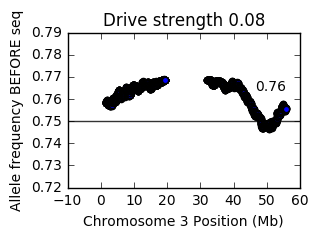

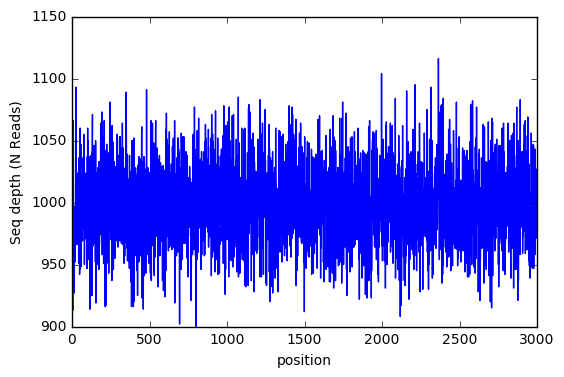

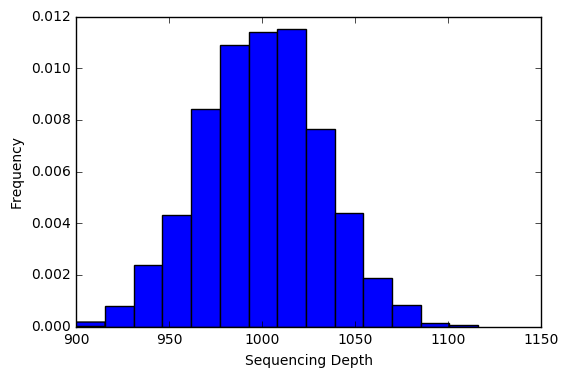

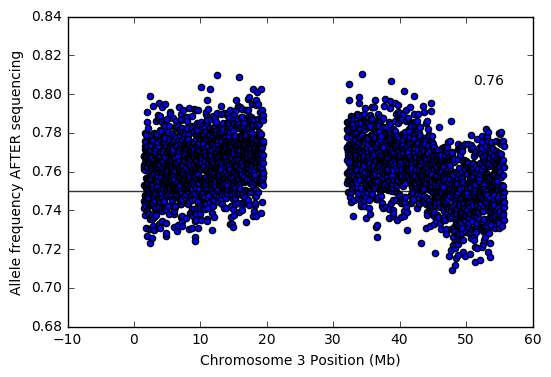

In [18]:
#def sim_drive_all_chrx

    #get number of loci per chromosome from n_total loci
    loci_per_chrx=total_num_loci/5

    #Do analysis on all arms
    chromosome_names=chromosome_arms

    #set up a dictionary, get recombination probabilities, physical locations, and genetic positions for each chromosome arm, store in dictionary
    chromosome_recombination_prob_dict={}
    phys_loc_dict={}
    g_pos_dict={}
    for chromosome in chromosome_names:
        recomb_freq_vec,phys_loc_vec,g_pos_vec=get_recombination_probability(chromosome, loci_per_chrx)
        chromosome_recombination_prob_dict[chromosome]=recomb_freq_vec
        phys_loc_dict[chromosome]=phys_loc_vec
        g_pos_dict[chromosome]=g_pos_vec

    #join the chromosome arm recombination probabilities together to get full chromosome
    recomb_freq_chrx2=np.hstack((chromosome_recombination_prob_dict["2L"],chromosome_recombination_prob_dict["2R"]))
    recomb_freq_chrx3=np.hstack((chromosome_recombination_prob_dict["3L"],chromosome_recombination_prob_dict["3R"]))
    recomb_freq_chrxX=chromosome_recombination_prob_dict["X"]

    #join the chromosome arm physical locations
    phys_loc_2L=phys_loc_dict["2L"] + chromosome_bounds_dict["2L"][0]
    phys_loc_2R=phys_loc_dict["2R"] + length_dict["2L"] + chromosome_bounds_dict["2R"][0]
    phys_loc_chrx2=np.hstack((phys_loc_2L,phys_loc_2R))

    phys_loc_3L=phys_loc_dict["3L"] + chromosome_bounds_dict["3L"][0]
    phys_loc_3R=phys_loc_dict["3R"] + length_dict["3L"] + chromosome_bounds_dict["3R"][0]
    phys_loc_chrx3=np.hstack((phys_loc_3L,phys_loc_3R))

    phys_loc_chrxX=phys_loc_dict["X"] + chromosome_bounds_dict["X"][0]

    #join the chromosome arm genetic distances
    g_pos_chrx2=np.hstack((g_pos_dict["2L"],g_pos_dict["2R"]))
    g_pos_chrx3=np.hstack((g_pos_dict["3L"],g_pos_dict["3R"]))
    g_pos_chrxX=g_pos_dict["X"]

    #make dictionary of recombination probs across full chromosome using zip command
    recomb_probs=[recomb_freq_chrx2, recomb_freq_chrx3, recomb_freq_chrxX]
    recomb_probs_dict=dict(zip(chromosome_numbers, recomb_probs))

    #commands for checking dimensions
    #for keys,values in recomb_probs_dict.items():
    #    print(keys)
    #    print(values.shape)

    #make the recombination guide for each chromosome based on n_ind
    recombination_guide_dict={}
    for chromosome in chromosome_numbers:
        recomb_guide_vec=build_recombination_guide(recomb_probs_dict[chromosome], n_individuals)
        recombination_guide_dict[chromosome]=recomb_guide_vec

    #commands for checking dimensions
    #for keys,values in recombination_guide_dict.items():
    #    print(keys)
    #    print(values.shape)

    #use above to simulate recombined chromosomes for a number of individuals
    #start=time.clock()
    haploid_chromosomes_dict={}
    for chromosome in chromosome_numbers:
        haploid_chrx=get_recombined_chromosomes(recombination_guide_dict[chromosome])
        haploid_chromosomes_dict[chromosome]=haploid_chrx

    #commands for checking 
    #for keys,values in haploid_chromosomes_dict.items():
    #    print(keys)
    #    print(values.shape)
    #print haploid_chromosomes
    #means=np.mean(haploid_chromosomes, axis=0)
    #print means

    #use genotypes of above set of chromosomes to simulate drive
    #start=time.clock()
    backcross_offspring_dict={}
    for chromosome in chromosome_numbers:
        if chromosome==chromosome_for_drive:
            backcross_offspring=sim_drive(drive_strength=drive_strength, drive_location=location_of_driver, drive_genotype=0, haploid_chromosomes=haploid_chromosomes_dict[chromosome])
            backcross_offspring_dict[chromosome]=backcross_offspring
        else:
            backcross_offspring=sim_drive(drive_strength=0, drive_location=location_of_driver, drive_genotype=0, haploid_chromosomes=haploid_chromosomes_dict[chromosome])
            backcross_offspring_dict[chromosome]=backcross_offspring

    #commands for checking      
    #for keys,values in backcross_offspring_dict.items():
    #    print(keys)
    #    print(values.shape)

    #add chromsomes from male in backcross
    #start=time.clock()
    complete_offspring_dict={}
    for chromosome in chromosome_numbers:
        complete_offspring_chrxs=add_male_genotypes(backcross_offspring_dict[chromosome],male_allele=0)
        complete_offspring_dict[chromosome]=complete_offspring_chrxs

    #for keys,values in complete_offspring_dict.items():
    #    print(keys)
    #    print(values.shape)

    #get allele frequencies prior to sequencing at each locus
    allele_freq_dict={}
    for chromosome in chromosome_numbers:
        means=np.mean(complete_offspring_dict[chromosome], axis=0)
        allele_freq_dict[chromosome]=means

    #for keys,values in allele_freq_dict.items():
    #    print(keys)
    #    print(values.shape)    

    #plot allele frequencies prior to sequencing
    if show_plots == "yes":
        plt.figure(1,figsize=(8, 9), dpi= 80, facecolor='w', edgecolor='k')

        plt.subplot(311)
        plt.scatter(phys_loc_chrx2[:-1],1-allele_freq_dict["2"])
        mean=round(np.mean(1-allele_freq_dict["2"]),2)
        plt.xlabel("Chr 2 Position (Mb)")
        plt.ylabel("Allele frequency before seq")
        plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='red')
        plt.annotate(str(mean), xy=(np.amax(phys_loc_chrx2),np.amax(1-allele_freq_dict["2"])), horizontalalignment='right', verticalalignment='top',color='red')

        plt.subplot(312)
        plt.scatter(phys_loc_chrx3[:-1],1-allele_freq_dict["3"])
        mean=round(np.mean(1-allele_freq_dict["3"]),2)
        plt.xlabel("Chr 3 Position (Mb)")
        plt.ylabel("Allele frequency before seq")
        plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='red')
        plt.annotate(str(mean), xy=(np.amax(phys_loc_chrx3),np.amax(1-allele_freq_dict["3"])), horizontalalignment='right', verticalalignment='top',color='red')

        plt.subplot(313)
        plt.scatter(phys_loc_chrxX,1-allele_freq_dict["X"])
        mean=round(np.mean(1-allele_freq_dict["X"]),2)
        plt.xlabel("X Position (Mb)")
        plt.ylabel("Allele frequency before seq")
        plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='red')
        plt.annotate(str(mean), xy=(np.amax(phys_loc_chrxX),np.amax(1-allele_freq_dict["X"])), horizontalalignment='right', verticalalignment='top',color='red')

        plt.show()
        #plt.savefig("before_seq.png")

    #sample alleles according to sequencing depth
    allele_freq_after_seq_dict={}
    for chromosome in chromosome_numbers:
        s=np.random.poisson(mean_depth,len(allele_freq_dict[chromosome])) #draw a sequencing depth
        sfloat=s.astype(float)
    
    if show_plots == "yes": #plot the drawn sequencing depths over chromosomes
        plt.plot(range(len(s)),s)
        plt.xlabel("position")
        plt.ylabel("Seq depth (N Reads)")
        plt.show()
        
        #plot the histogram of drawn sequencing depths
        plt.clf()
        plt.figure(1,figsize=(3, 2), dpi= 80, facecolor='w', edgecolor='k')
        count, bins, ignored = plt.hist(s, 14, normed=True)
        plt.xlabel('Sequencing Depth')
        plt.ylabel('Frequency')
        plt.savefig("Seqdepth_hist_mean_depth50.png")
        plt.show()

    alleles_seq=sp.stats.binom.rvs(s, allele_freq_dict[chromosome]) #get the number of reads per P1 allele
    alleles_seq_float=alleles_seq.astype(float)
    final_alleles=np.divide(alleles_seq_float,sfloat) #divide by depth to get frequency
    allele_freq_after_seq_dict[chromosome]=final_alleles

    if show_plots == "yes":
        plt.clf()
        plt.figure(1,figsize=(8, 9), dpi= 80, facecolor='w', edgecolor='k')

        plt.subplot(311)
        freqs=allele_freq_after_seq_dict["2"]
        mean=round(np.mean(1-allele_freq_after_seq_dict["2"]), 2)
        plt.scatter(phys_loc_chrx2[:-1],1-freqs)
        plt.xlabel("Chr2 Position (Mb)")
        plt.ylabel("Allele frequency after sequencing")
        plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='red')
        plt.annotate(str(mean), xy=(np.amax(phys_loc_chrx2[:-1]),np.amax(1-allele_freq_after_seq_dict["2"])), horizontalalignment='right', verticalalignment='top',color='red')

        plt.subplot(312)
        freqs=allele_freq_after_seq_dict["3"]
        mean=round(np.mean(1-allele_freq_after_seq_dict["3"]), 2)
        plt.scatter(phys_loc_chrx3[:-1],1-freqs)
        plt.xlabel("Chr3 Position (Mb)")
        plt.ylabel("Allele frequency after sequencing")
        plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='red')
        plt.annotate(str(mean), xy=(np.amax(phys_loc_chrx3[:-1]),np.amax(1-allele_freq_after_seq_dict["3"])), horizontalalignment='right', verticalalignment='top',color='red')

        plt.subplot(313)
        freqs=allele_freq_after_seq_dict["X"]
        mean=round(np.mean(1-allele_freq_after_seq_dict["X"]), 2)
        plt.scatter(phys_loc_chrxX,1-freqs)
        plt.xlabel("ChrX Position (Mb)")
        plt.ylabel("Allele frequency after sequencing")
        plt.axhline(y=0.75, xmin=0, xmax=means.shape[0], color='red')
        plt.annotate(str(mean), xy=(np.amax(phys_loc_chrxX[:-1]),np.amax(1-allele_freq_after_seq_dict["X"])), horizontalalignment='right', verticalalignment='top',color='red')

        plt.show()
        #plt.savefig("After_seq.png")
        
        #test for drive
        parameters=[drive_strength, location_of_driver, chromosome_for_drive, n_individuals, total_num_loci, mean_depth]
        test_results=test_for_drive(chromosome_for_drive, "yes", g_pos, phys_loc)
        output=np.append(parameters, test_results)
        print output
